<a href="https://colab.research.google.com/github/jhwnoh/UST-GenerativeModels/blob/main/P1_AutoregressiveGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Handling with SMILES

Install rdkit & convert SMILES to molecules

In [ ]:
!pip install rdkit

import rdkit
from rdkit.Chem import MolFromSmiles,MolToSmiles

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 29.3 MB/s eta 0:00:00


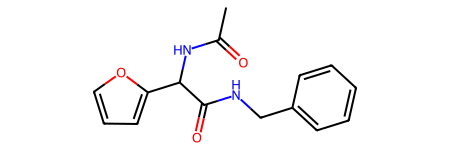

In [ ]:
smi = 'CC(=O)NC(C(=O)NCc1ccccc1)c1ccco1'
mol = MolFromSmiles(smi)
mol

In [ ]:
smi_from_mol = MolToSmiles(mol)
smi_from_mol

'CC(=O)NC(C(=O)NCc1ccccc1)c1ccco1'

In [ ]:
smi = 'COc1cc(CNc2ccc(C)cc'
mol = MolFromSmiles(smi)
mol

[06:48:13] SMILES Parse Error: extra open parentheses for input: 'COc1cc(CNc2ccc(C)cc'


# 2. Data loading, find unique tokens from dataset

Load SMILES data from MOSES (https://github.com/molecularsets/moses)

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

df = pd.read_csv('https://media.githubusercontent.com/media/molecularsets/moses/master/data/train.csv')
smis_train = list(df.SMILES)
Ntr = [len(smi) for smi in smis_train]

df = pd.read_csv('https://media.githubusercontent.com/media/molecularsets/moses/master/data/test.csv')
smis_test = list(df.SMILES)
Nt = [len(smi) for smi in smis_test]

print('Maximum length in train and test data')
print(np.max(Ntr),np.max(Nt))

Maximum length in train and test data
57 55


Find unique tokens in training set

In [ ]:
toks = []
for smi in tqdm(smis_train):
  toks += list(set(smi))
  toks = list(set(toks))
toks = list(set(toks))

print('Total number of tokens;',len(toks))

100%|██████████| 1584663/1584663 [00:08<00:00, 181523.41it/s]

Total number of tokens; 26


Check whether all SMILES in test set can be tokenzied using the pre-defined token set.

In [ ]:
set_t = []
for smi in tqdm(smis_test):
  set_t += list(set(smi))
  set_t = list(set(set_t))
set_t = list(set(set_t))

failed = []
for t in set_t:
  if not t in toks:
    print(t,'is not in the pre-defined token set')
    failed.append(t)

if len(failed) == 0:
  print('All SMILES in test set can be tokenized using the pre-defined token set')

100%|██████████| 176074/176074 [00:01<00:00, 146719.32it/s]

All SMILES in test set can be tokenized using the pre-defined token set


In [ ]:
toks

['r',
 'B',
 ']',
 'C',
 '4',
 '[',
 'H',
 '5',
 's',
 'l',
 '(',
 '#',
 '6',
 'c',
 '3',
 '=',
 'F',
 '-',
 'N',
 'O',
 'o',
 ')',
 '1',
 '2',
 'S',
 'n']

# 3. Define dataloader, model

Define **Dataset** class

In [ ]:
import torch
from torch.utils.data import Dataset

class MolData(Dataset):
  def __init__(self,smis,toks):
    self.smis = smis
    self.toks = toks + ['<','>'] #'<'; start of sequence, '>'; end of sequence
    self.Ntok = len(toks)
    self.Nmax = 60

  def __len__(self):
    return len(self.smis)

  def __getitem__(self,idx):
    smi = '<'+self.smis[idx]+'>'
    smi += '>'*(self.Nmax-len(smi))

    x_all = np.array([self.toks.index(s) for s in smi]).flatten()

    x = x_all[:-1] #input
    y = x_all[1:] #output

    x = torch.LongTensor(x)
    y = torch.LongTensor(y)
    return x,y

In [ ]:
train_data = MolData(smis_train,toks)
train_data[0]

(tensor([26,  3,  3,  3, 24, 10, 15, 19, 21, 13, 22, 13, 13, 13, 23,  5, 25,  6,
          2, 13, 10, 15, 18,  3, 10, 15, 19, 21, 19,  3, 21,  5, 25,  6,  2, 13,
         23, 13, 22, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27, 27, 27, 27]),
 tensor([ 3,  3,  3, 24, 10, 15, 19, 21, 13, 22, 13, 13, 13, 23,  5, 25,  6,  2,
         13, 10, 15, 18,  3, 10, 15, 19, 21, 19,  3, 21,  5, 25,  6,  2, 13, 23,
         13, 22, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27, 27, 27, 27]))

Define **Model** class

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self,dim_x0,dim_x1,dim_h,n_layer,d_ratio):
        super(CharRNN,self).__init__()

        self.emb_layer = nn.Embedding(dim_x0,dim_x1)

        self.rnn = nn.RNN(dim_x1,dim_h,
                        num_layers=n_layer,
                        dropout = d_ratio,
                        batch_first = True)

        self.out = nn.Sequential(
                  nn.Linear(dim_h,dim_h),
                  nn.ReLU(),
                  nn.Linear(dim_h,dim_x0))


    def forward(self,x_in,h0=None):
        x0 = self.emb_layer(x_in)
        x1,h1 = self.rnn(x0,h0)
        x2 = self.out(x1)
        return x2,h1

In [ ]:
model = CharRNN(28,128,512,3,0.1)
input = train_data[0][0]
out,_ = model(input)
print(input.shape)
print(out.shape)

torch.Size([59])
torch.Size([59, 28])


In [ ]:
ce_loss = nn.CrossEntropyLoss()
tgt = train_data[0][1].view(-1)
loss = ce_loss(out.reshape(-1,28),tgt)
print(loss)

tensor(3.3560, grad_fn=<NllLossBackward0>)


# 4. Define **Sampling** code

In [ ]:
def Sampling(sampler,n_sample,max_len,tok_lib):
    sampler.eval()
    with torch.no_grad():
        inits = torch.LongTensor([26]*n_sample)
        loader = DataLoader(inits,batch_size=100)

        Sampled = []
        for inp in tqdm(loader):
            x_in = inp.reshape(-1,1)

            x_hat = []
            h = None
            for seq_iter in range(max_len):
                out,h = sampler(x_in,h)
                prob = F.softmax(out,dim=-1).squeeze(1)
                x_in = torch.multinomial(prob,1)

                x_hat.append(x_in.cpu().detach().numpy())

            x_hat = np.hstack(x_hat)
            Sampled.append(x_hat)

        Sampled = np.vstack(Sampled)

        Mols = []
        for s in Sampled:
            n_end = np.sum(s==27)

            if n_end == 0:
                continue

            n = np.min(np.where(s==27)[0])
            m = ''.join(tok_lib[s[:n]].tolist())
            Mols.append(m)

        Vals = []
        for smi in Mols:
            mol = MolFromSmiles(smi)
            if not mol is None:
                Vals.append(MolToSmiles(mol))

        Uni = list(set(Vals))
        return Vals,len(Vals),len(Uni)

# 5. Define trainer code

In [ ]:
import rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
import torch.optim as optim

df = pd.read_csv('https://media.githubusercontent.com/media/molecularsets/moses/master/data/train.csv')
smis_ = list(df.SMILES)

toks = []
for smi in tqdm(smis_):
  toks += list(set(smi))
  toks = list(set(toks))
toks = list(set(toks))

np.random.seed(1)
np.random.shuffle(smis_)

n_train = 1000000

smi_train = smis_[:n_train]

batch_size = 64

train_data = MolData(smi_train,toks)
tok_lib = np.array(train_data.toks)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)

model = CharRNN(28,128,480,3,0.2)

lr = 2e-4
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

num_epoch = 20
max_norm = 5
num_iter = 0
for ep in range(num_epoch):
    model.train()
    for inp in tqdm(train_loader):
        x_in = inp[0]
        tgt = inp[1].view(-1)

        x_out,_ = model(x_in)

        loss = ce_loss(x_out.reshape(-1,28),tgt)

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(),max_norm)
        optimizer.step()

        num_iter += 1

        if num_iter % 10 == 0:
            samples,val,uni = Sampling(model,100,60,tok_lib)
            print(ep,samples[0],val,uni)


# 6. Using the pretrained model

In [ ]:
model = CharRNN(28,128,480,3,0.2)
chkpt = torch.load('your/path',map_location='cpu')
model.load_state_dict(chkpt['state_dict'])
samples,val,uni = Sampling(model,10000,100,tok_lib)